In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out_TS, S_traveller_opt_out_TS
from MaaSSim.day_to_day import d2d_kpi_veh, d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 2 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.20)
params.platforms.discount = float(0.0)
params.platforms.daily_marketing = True

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.mn = 100/12 # for NL
params.d2d.ini_att = 0.01
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.seed = 1
params.paths.requests = 'Amsterdam_requests.csv'
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
params.threshold_u = 0.005
params.max_revenue = 4000 # maximum revenue with the initial fare
params.alpha = 1.0
params.initial_capital = 50000
params.expense_per_day = 500
params.random_ini_position = False
params.step_size = 0.2 # euro/km
params.min_fare, params.max_fare  = 0.0, 3.0
params.initial_fares = (1.0,1.0)

params.nD = 1000
params.turnover_interval = 50 #---------------------------------
params.nP = 2000
params.nV = 200

In [ ]:
sim = MaaSSim.simulators.Try_and_Select(params=params, f_driver_out=S_driver_opt_out_TS,f_trav_out=S_traveller_opt_out_TS,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
23-12-24 11:24:03-WARNING-Setting up 4h simulation at 2024-12-23 09:23:35 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
============ P1 TURN ============
23-12-24 11:24:11-WARNING-simulation time 3.1 s
Day =  0 --- on the Left cell with fare 0.8
(np1,vp1) =  (0, 0)     (np2,vp2) =  (0, 0)
--------------------------------------------
23-12-24 11:24:21-WARNING-simulation time 3.8 s
Day =  1 --- on the Left cell with fare 0.8
(np1,vp1) =  (20, 1)     (np2,vp2) =  (20, 2)
--------------------------------------------
23-12-24 11:24:33-WARNING-simulation time 5.5 s
Day =  2 --- on the Left cell with fare 0.8
(np1,vp1) =  (36, 8)     (np2,vp2) =  (29, 4)
--------------------------------------------
23-12-24 11:24:44-WARNING-simulation time 5.1 s
Day =  3 --- on the Left cell with fare 0.8
(np1,vp1) =  (51, 2)     (np2,vp2) =  (50, 4)
--------------------------------------------
23-12-24 11:24:57-WARNING-simulation time 6.3 s
Day =  4 --- on 

In [9]:
sim.fare_trajectory

[(1.0, 1.0),
 (1.0, 1.2),
 (1.0, 1.2),
 (1.0, 1.4),
 (1.2, 1.4),
 (1.2, 1.4),
 (1.4, 1.4),
 (1.4, 1.6),
 (1.6, 1.6),
 (1.6, 1.8),
 (1.6, 1.8),
 (1.6, 1.8),
 (1.8, 1.8),
 (1.8, 2.0),
 (1.6, 2.0),
 (1.6, 1.8),
 (1.8, 1.8),
 (1.8, 2.0),
 (1.6, 2.0),
 (1.6, 1.8),
 (1.8, 1.8)]

In [225]:
sim.competition_trajectory['P1'][-1]

(3.0, 0.086100684, 344.402736, 0.09246999999999998)

In [ ]:
Solutions:
    1- make agents to leave faster X
    2- prolong the interval X
    3- mean function for the first and second half V
    4- increase hate days
    5- set utility threshold V
    6- if not max utility get closer to the max utility fare V

In [37]:
def smooth(y,w=7,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

In [168]:
x = [i for i in range(0,1000)]

In [55]:
sim.res[0].plat_exp.revenue[1]

109.88032000000001

In [172]:
len(e)

1000

In [173]:
p = []
e = []
r = []

for d in range(0,1000):
    
    df = sim.res[d].pax_exp
    p.append(len(df[df.platform_id==1]))
    e.append(len(df[df.P1_EXPERIENCE_U>0.01]))

<AxesSubplot:>

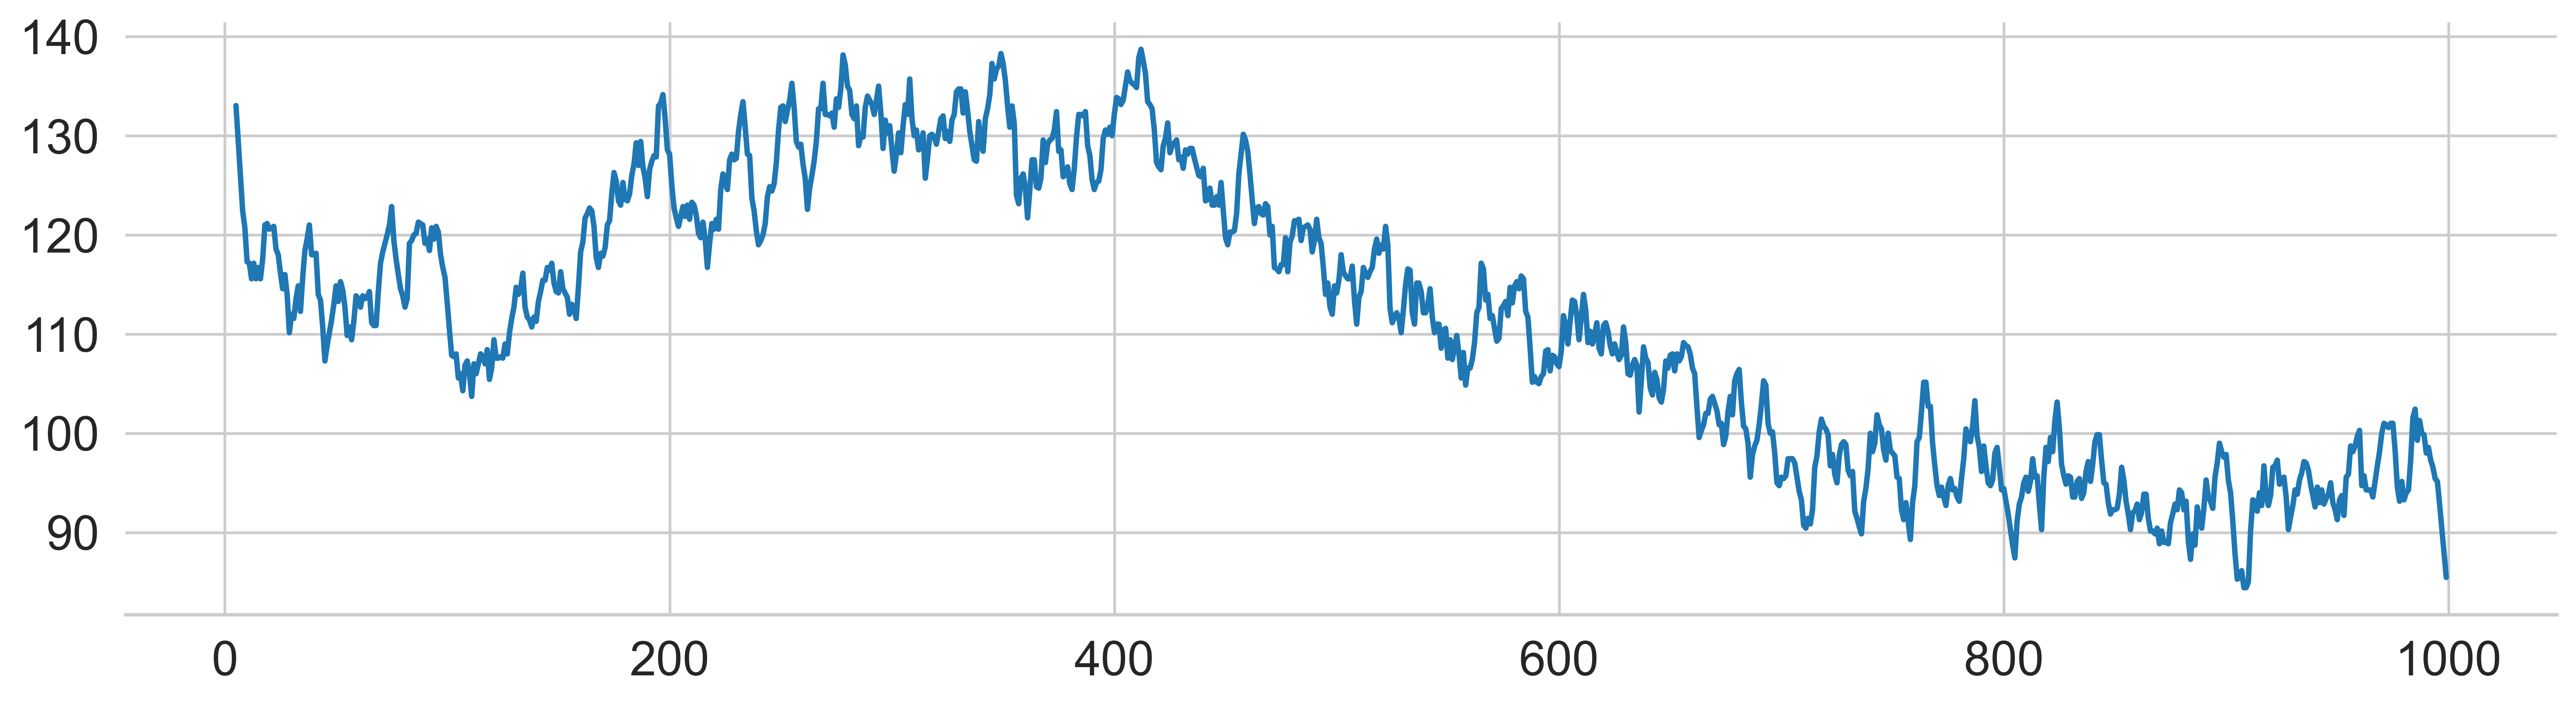

In [179]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

c1 = 'C0'
c2 = 'C3'

sns.lineplot(x=x, y=smooth(p), color=c1, lw=2)
# sns.lineplot(x=x, y=e, color=c2, lw=2)

In [8]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    veh_exp = sim.res[d].veh_exp
    pax_exp = sim.res[d].pax_exp
    plat_exp = sim.res[d].plat_exp
    platforms = sim.res[d].platforms
    
    df_d.at[d, 'P1_EXPERIENCE_U'] = pax_exp.P1_EXPERIENCE_U.mean()
    df_d.at[d, 'P2_EXPERIENCE_U'] = pax_exp.P2_EXPERIENCE_U.mean()
    df_d.at[d, 'P1_WOM_U'] = pax_exp.P1_WOM_U.mean()
    df_d.at[d, 'P2_WOM_U'] = pax_exp.P2_WOM_U.mean()
    df_d.at[d, 'P1_MARKETING_U'] = pax_exp.P1_MARKETING_U.mean()
    df_d.at[d, 'P2_MARKETING_U'] = pax_exp.P2_MARKETING_U.mean()
    df_d.at[d, 'P1_OUT'] = pax_exp[pax_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P2_OUT'] = pax_exp[pax_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P1_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==1].ACTUAL_WT.mean()
    df_d.at[d, 'P2_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==2].ACTUAL_WT.mean()
    df_d.at[d, 'P1_MATCHING_T'] = pax_exp[pax_exp.platform_id==1].MATCHING_T.mean()
    df_d.at[d, 'P2_MATCHING_T'] = pax_exp[pax_exp.platform_id==2].MATCHING_T.mean()
    df_d.at[d, 'P1_PICKUP_T'] = veh_exp[veh_exp.platform_id==1].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==1].nRIDES.mean()*60)
    df_d.at[d, 'P2_PICKUP_T'] = veh_exp[veh_exp.platform_id==2].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==2].nRIDES.mean()*60)
    df_d.at[d, 'PICKUP_T'] = veh_exp[veh_exp.OUT==False].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.OUT==False].nRIDES.mean()*60)
    
    df_d.at[d, 'P1_fare'] = plat_exp.fare[1]; df_d.at[d, 'P2_fare'] = plat_exp.fare[2]
    df_d.at[d, 'P1_revenue'] = plat_exp.revenue[1]; df_d.at[d, 'P2_revenue'] = plat_exp.revenue[2]
    df_d.at[d, 'P1_remaining_capital'] = plat_exp.remaining_capital[1]; df_d.at[d, 'P2_remaining_capital'] = plat_exp.remaining_capital[2]
    
    df_s.at[d, 'P1_EXPERIENCE_U'] = veh_exp.P1_EXPERIENCE_U.mean()
    df_s.at[d, 'P2_EXPERIENCE_U'] = veh_exp.P2_EXPERIENCE_U.mean()
    df_s.at[d, 'P1_WOM_U'] = veh_exp.P1_WOM_U.mean()
    df_s.at[d, 'P2_WOM_U'] = veh_exp.P2_WOM_U.mean()
    df_s.at[d, 'P1_MARKETING_U'] = veh_exp.P1_MARKETING_U.mean()
    df_s.at[d, 'P2_MARKETING_U'] = veh_exp.P2_MARKETING_U.mean()
    df_s.at[d, 'P1_OUT'] = veh_exp[veh_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P2_OUT'] = veh_exp[veh_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P1_IDLE_TIME'] = veh_exp[veh_exp.platform_id==1].IDLE_TIME.mean()/60
    df_s.at[d, 'P2_IDLE_TIME'] = veh_exp[veh_exp.platform_id==2].IDLE_TIME.mean()/60
    df_s.at[d, 'P1_REVENUE'] = veh_exp[veh_exp.platform_id==1].REVENUE.mean()
    df_s.at[d, 'P2_REVENUE'] = veh_exp[veh_exp.platform_id==2].REVENUE.mean()
    df_s.at[d, 'P1_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==1].ACTUAL_INC.mean()
    df_s.at[d, 'P2_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==2].ACTUAL_INC.mean()
    df_s.at[d, 'P1_COST'] = veh_exp[veh_exp.platform_id==1].COST.mean()
    df_s.at[d, 'P2_COST'] = veh_exp[veh_exp.platform_id==2].COST.mean()
    
    if d==0: d_cols = df_d.columns.values.tolist()
    if d==0: s_cols = df_s.columns.values.tolist()
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in d_cols]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in s_cols]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        
run_id = '1.0_1_1'
df_d.to_csv('csv/1.1/demand_{}.csv'.format(run_id))
df_s.to_csv('csv/1.1/supply_{}.csv'.format(run_id))

[autoreload of MaaSSim.simulators failed: Traceback (most recent call last):
  File "C:\Users\farno\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\farno\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\farno\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\farno\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\farno\OneDrive\Documents\GitHub\MaaSSim